# Prepare Google Colab Environment

In [1]:
import torch

In [2]:
import os
from os.path import join
saved_models_dir = '/home/pgrad1/2417023z/DFU2024/STEGO/checkpoint/DFUdata/directory_exp1_date_Aug12_13-00-23/'
os.makedirs(saved_models_dir, exist_ok=True)
saved_model_name = "epoch=47-step=2999.ckpt"

In [ ]:
saved_models_dir = '/home/pgrad1/2417023z/DFU2024/STEGO/checkpoint/DFUdata/directory_exp1_date_Aug12_13-45-52/'
saved_model_name = 'epoch=11-step=719.ckpt'

In [ ]:
saved_models_dir = '/home/pgrad1/2417023z/DFU2024/STEGO/checkpoint/DFUdata/directory_exp1_date_Aug12_15-50-33'
saved_model_name =  'last-epoch/epoch=31-step=1999.ckpt'

In [270]:
saved_models_dir = '/home/pgrad1/2417023z/DFU2024/STEGO/checkpoint/DFUdata/directory_exp1_date_Aug20_11-30-01/'
saved_model_name =  'epoch=6-step=779.ckpt'

In [3]:
saved_models_dir = '/home/pgrad1/2417023z/DFU2024/STEGO/checkpoint/DFUdata/directory_exp1_date_Aug20_11-48-38/'
saved_model_name =  'epoch=3-step=399.ckpt'

In [ ]:
saved_models_dir = '/home/pgrad1/2417023z/DFU2024/STEGO/checkpoint/DFUdata/directory_exp1_date_Aug19_16-56-32/'
saved_model_name =  'epoch=7-step=799-Copy1.ckpt'

In [ ]:
saved_models_dir = '/home/pgrad1/2417023z/DFU2024/STEGO/checkpoint/DFUdata/directory_dino_attn_date_Aug23_21-52-41/'
saved_model_name =  'last-epoch/epoch=6-step=874-Copy1.ckpt'

In [271]:
join(saved_models_dir, saved_model_name)

'/home/pgrad1/2417023z/DFU2024/STEGO/checkpoint/DFUdata/directory_exp1_date_Aug20_11-30-01/epoch=6-step=779.ckpt'

In [272]:
# Clear GPU cache
torch.cuda.empty_cache()
# For debugging purposes, set CUDA_LAUNCH_BLOCKING
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load pretrained STEGO

In [273]:
import importlib
import train_segmentation
# Reload the module
importlib.reload(train_segmentation)
# Now you can use the reloaded module as usual
from train_segmentation import LitUnsupervisedSegmenter

model = LitUnsupervisedSegmenter.load_from_checkpoint(join(saved_models_dir, saved_model_name)).cuda()

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


# Load Image

In [6]:
from PIL import Image
import requests
from io import BytesIO
from torchvision.transforms.functional import to_tensor
from utils import get_transform
import numpy as np

image_path = '/home/pgrad1/2417023z/DFU2024/dino_norm/DFU_test/200019.jpg'
img = Image.open(image_path)
transform = get_transform((224,224), False, "center")
img = transform(img).unsqueeze(0).cuda()

In [ ]:
transform = get_transform((224,224), False, "center")
img = transform(img).unsqueeze(0).cuda()

In [ ]:
img.shape

In [ ]:
#image_path = '/home/pgrad1/2417023z/DFU2024/STEGO/results/DFU_test/200001.png'
#image_path = '/home/pgrad1/2417023z/DFU2024/dino_norm/DFU_test/201289.jpg'
img = Image.open(image_path)
#transform = get_transform(448, False, "center")
#img = transform(img).unsqueeze(0).cuda()

In [ ]:
img.size

In [438]:
import os
from PIL import Image

# Define paths
seg_path = '/home/pgrad1/2417023z/DFU2024/STEGO/results/DFU_test_tuned_bb_399/'
orig_path = '/home/pgrad1/2417023z/DFU2024/dino_norm/DFU_test/'

def get_image_size(image_path):
    """Returns the size of the image (width, height)."""
    with Image.open(image_path) as img:
        return img.size

def resize_image(image_path, target_size):
    """Resizes the image to the target size and overwrites it."""
    with Image.open(image_path) as img:
        resized_img = img.resize(target_size, Image.ANTIALIAS)
        resized_img.save(image_path)  # Overwrite the existing image

def process_images(seg_path, orig_path):
    """Resizes segmentation images to match the size of original images if needed."""
    # Get list of original image filenames
    # Get list of original image filenames with .jpg extension
    orig_filenames = [f for f in os.listdir(orig_path) if f.endswith('.jpg')]

    # Process each original image
    for orig_fname in orig_filenames:
        # Construct corresponding segmentation filename with .png extension
        seg_fname = os.path.splitext(orig_fname)[0] + '.png'
        orig_img_path = os.path.join(orig_path, orig_fname)
        seg_img_path = os.path.join(seg_path, seg_fname)
        
        # Check if segmentation image exists
        if os.path.exists(seg_img_path):
            # Get sizes
            orig_size = get_image_size(orig_img_path)
            seg_size = get_image_size(seg_img_path)

            # Compare sizes
            if orig_size != seg_size:
                print(f"Size mismatch for {orig_fname}: Original size {orig_size}, Segmentation size {seg_size}")

                # Resize segmentation image to match the original size and overwrite it
                resize_image(seg_img_path, orig_size)
                print(f"Resized {orig_fname} to match original size {orig_size}")
        else:
            print(f"Segmentation image for {orig_fname} not found in {seg_path}")

# Run the processing
process_images(seg_path, orig_path)

# Query model and pass result through CRF

In [ ]:
import torch.nn.functional as F
from crf import dense_crf
import torch

with torch.no_grad():
    code1 = model(img)
    code2 = model(img.flip(dims=[3]))
    code  = (code1 + code2.flip(dims=[3])) / 2
    code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
    linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
    cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

    single_img = img[0].cpu()
    linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
    cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

In [ ]:
cluster_probs = torch.argmax(cluster_probs,1).squeeze(0)

In [ ]:
cluster_probs.shape

In [ ]:
import torch.nn.functional as F
from crf import dense_crf
import torch

with torch.no_grad():
    feats= model(img)
    code = F.interpolate(feats, img.shape[-2:], mode='bilinear', align_corners=False)
    linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
    cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

    single_img = img[0].cpu()
    linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
    cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

In [ ]:
cluster_pred.shape

# Visualize Result

Note that cluster predictions will not be matched with ground truth classes in this example. For hungarian matching please use: `eval_segmentation.py`

In [324]:
import importlib
import train_segmentation
# Reload the module
importlib.reload(train_segmentation)
# Now you can use the reloaded module as usual
from train_segmentation import LitUnsupervisedSegmenter

model = LitUnsupervisedSegmenter.load_from_checkpoint('/home/pgrad1/2417023z/DFU2024/STEGO/checkpoint/DFUdata/directory_exp1_date_Aug19_22-12-57/epoch=11-step=1459.ckpt').cuda()

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


In [454]:
model = LitUnsupervisedSegmenter.load_from_checkpoint('/home/pgrad1/2417023z/DFU2024/STEGO/checkpoint/DFUdata/directory_exp1_date_Aug20_11-48-38/epoch=3-step=399.ckpt').cuda()

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


In [455]:
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects
from skimage.measure import label
from skimage.measure import label, regionprops

In [922]:
image_path = '/home/pgrad1/2417023z/DFU2024/dino_norm/DFU_test/200054.jpg'
img = Image.open(image_path)
transform = get_transform((240,320), False, "center")
img = transform(img).unsqueeze(0).cuda()

In [923]:
import torch.nn.functional as F
from crf import dense_crf
import torch

with torch.no_grad():
    code1 = model(img)
    code2 = model(img.flip(dims=[3]))
    code  = (code1 + code2.flip(dims=[3])) / 2
    code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
    linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
    cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()
    cluster_pred = cluster_probs[0].argmax(0).cpu()

In [924]:
cluster_pred[cluster_pred == 7]  = 10
cluster_pred[cluster_pred == 8]  = 9

In [925]:
k = 12

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


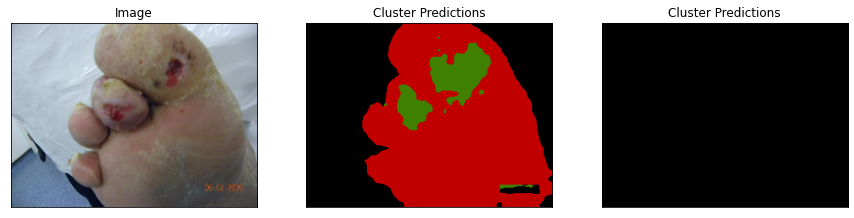

In [926]:
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes
fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow(unnorm(img)[0].permute(1,2,0).cpu())
ax[0].set_title("Image")
ax[1].imshow(model.label_cmap[cluster_pred])
ax[1].set_title("Cluster Predictions")
ax[2].imshow(cluster_pred==8,'gray')
ax[2].set_title("Cluster Predictions")
remove_axes(ax)

In [927]:
k = 7

In [928]:
model.eval().cuda()
par_model = model.net

In [929]:
# Initial forward pass
feats, code1 = par_model(img)
feats, code2 = par_model(img.flip(dims=[3]))
code = (code1 + code2.flip(dims=[3])) / 2
code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
cluster_probs = model.cluster_probe(code, 2, log_probs=True)
cluster_preds = cluster_probs.argmax(1)

# Binarize the cluster predictions
binary_cluster_preds = (cluster_preds == k).to(torch.uint8) * 255

In [930]:
binary_cluster_preds.shape

torch.Size([1, 240, 320])

In [931]:
pred = binary_cluster_preds[0]

In [932]:
processed_preds = []
# Fill holes and extract bounding boxes
filled_pred = binary_fill_holes(pred.cpu().numpy()).astype(np.uint8) * 255
label_pred = label(filled_pred)
props = regionprops(label_pred)

In [933]:
label_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

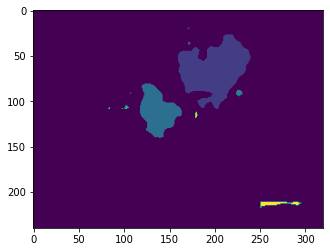

In [934]:
plt.imshow(label_pred)

In [935]:
len(props)

11

In [936]:
batch_idx = 0

In [937]:
for prop in props:
    # Extract bounding box coordinates
    min_row, min_col, max_row, max_col = prop.bbox

    # Crop the original image corresponding to the batch index
    cropped_img = img[batch_idx:batch_idx+1, :, min_row:max_row, min_col:max_col]

    # Resize the cropped image to 224x224 for ViT
    cropped_img_resized = F.interpolate(cropped_img, size=(224, 224), mode='bilinear', align_corners=False)

    # Run the cropped image through the network for refinement
    refined_feats, refined_code1 = par_model(cropped_img_resized)
    refined_feats, refined_code2 = par_model(cropped_img_resized.flip(dims=[3]))
    refined_code = (refined_code1 + refined_code2.flip(dims=[3])) / 2
    refined_code = F.interpolate(refined_code, size=(224, 224), mode='bilinear', align_corners=False)
    refined_cluster_probs = model.cluster_probe(refined_code, 2, log_probs=True)
    refined_cluster_preds = refined_cluster_probs.argmax(1)

    # Resize the refined segmentation back to the original bounding box size
    refined_pred_resized = F.interpolate(refined_cluster_preds.unsqueeze(1).float(), 
                                         size=(max_row - min_row, max_col - min_col), 
                                         mode='bilinear', align_corners=False).squeeze(1)

    # Convert back to binary mask
    refined_pred_resized = (refined_pred_resized == k).to(torch.uint8) * 255

    # Insert the refined segmentation back into the original size
    pred[min_row:max_row, min_col:max_col] = refined_pred_resized.to(pred.device)

seg = binary_fill_holes(pred.cpu().numpy()).astype(np.uint8) * 255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


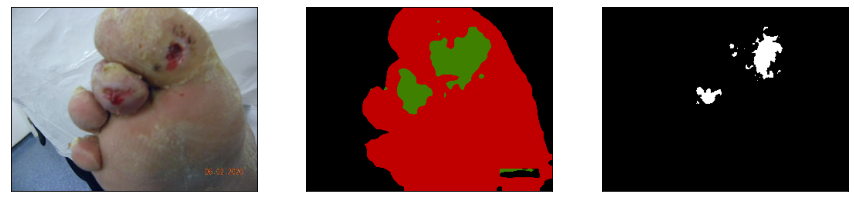

In [938]:
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes
fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow(unnorm(img)[0].permute(1,2,0).cpu())
ax[1].imshow(model.label_cmap[cluster_pred])
ax[2].imshow(seg,'gray')
remove_axes(ax)

In [903]:
binary_pred_img = Image.fromarray(pred.cpu().numpy())
                 # Resize the image to the fixed size
binary_pred_img_resized = binary_pred_img.resize((640,480), Image.NEAREST)

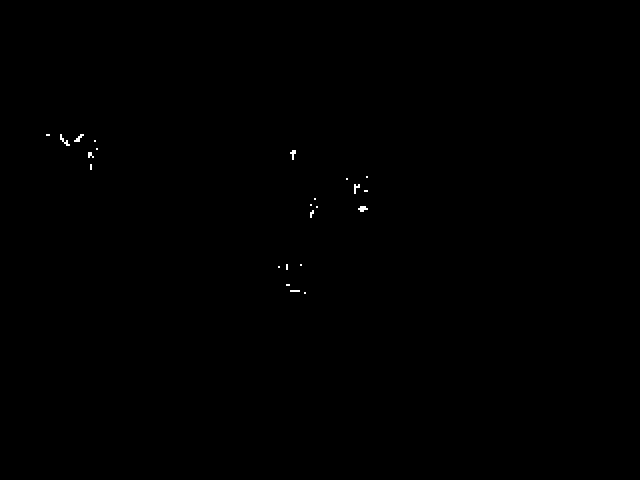

In [904]:
binary_pred_img_resized

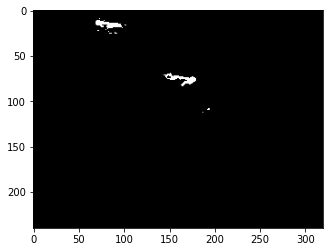

In [165]:
plt.imshow(pred.cpu().numpy(),'gray')

In [ ]:
refined_pred_resized.shape

In [ ]:
plt.imshow(refined_pred_resized.cpu().numpy()==9)

In [ ]:
pred.max()

In [ ]:
plt.imshow(pred.cpu().numpy(),'gray')

In [ ]:
plt.imshow(seg)

In [ ]:
cluster_index = 0

In [ ]:
import os
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from crf import dense_crf
from utils import unnorm, remove_axes

# Assuming the model, get_transform function, and other necessary imports are already done

# Directory containing the images
#image_dir = '/home/pgrad1/2417023z/DFU2024/STEGO/src/data/DFUdata/imgs/val/'
image_dir = '/home/pgrad1/2417023z/DFU2024/dino_norm/DFU_test/'
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)][12:24]  # Get 12 image paths

# Transform for all images
transform = get_transform(448, False, "center")

# Load and transform all images into a single batch
images = [transform(Image.open(img_path)).unsqueeze(0) for img_path in image_paths]
batch = torch.cat(images, dim=0).cuda()  # Stack all images into a batch

with torch.no_grad():
    # Process the entire batch
    code1 = model(batch)
    code2 = model(batch.flip(dims=[3]))
    code = (code1 + code2.flip(dims=[3])) / 2
    code = F.interpolate(code, batch.shape[-2:], mode='bilinear', align_corners=False)
    
    # Linear and cluster probes
    linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
    cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

In [ ]:
# Initialize the figure for displaying results
fig, axs = plt.subplots(len(image_paths), 5, figsize=(25, 5 * len(image_paths)))

# Loop over each image in the batch
for idx in range(len(image_paths)):
    single_img = batch[idx].cpu()
    linear_pred = dense_crf(single_img, linear_probs[idx]).argmax(0)
    cluster_pred = dense_crf(single_img, cluster_probs[idx]).argmax(0)

    # Predictions without dense_crf
    linear_pred_no_crf = linear_probs[idx].argmax(0)
    cluster_pred_no_crf = cluster_probs[idx].argmax(0)

    # Plotting
    axs[idx, 0].imshow(unnorm(batch[idx].unsqueeze(0))[0].permute(1, 2, 0).cpu())
    axs[idx, 0].set_title("Image")

    axs[idx, 1].imshow(model.label_cmap[cluster_pred_no_crf])
    axs[idx, 1].set_title("Cluster Pred No CRF")

    axs[idx, 2].imshow(model.label_cmap[linear_pred_no_crf])
    axs[idx, 2].set_title("Linear Pred No CRF")

    axs[idx, 3].imshow((cluster_pred == cluster_index).astype(int),'gray')
    axs[idx, 3].set_title("Cluster Predictions")

    axs[idx, 4].imshow(model.label_cmap[linear_pred])
    axs[idx, 4].set_title("Linear Probe Predictions")

    remove_axes(axs[idx, :])

plt.tight_layout()
plt.show()


In [ ]:
unnorm(batch[idx]).shape

In [ ]:
from PIL import Image
import os

def convert_jpg_to_png(folder_path):
    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.jpg'):
            # Define the full path to the current file
            jpg_file = os.path.join(folder_path, filename)
            
            # Open the .jpg file
            with Image.open(jpg_file) as img:
                # Define the new filename with .png extension
                png_filename = os.path.splitext(filename)[0] + '.png'
                png_file = os.path.join(folder_path, png_filename)
                
                # Save the image in .png format
                img.save(png_file, 'PNG')
            
            # Optionally, remove the original .jpg file
            # os.remove(jpg_file)

    print("Conversion completed!")

# Set the folder path where your .jpg files are located
folder_path = '../results/DFU_test/'

# Call the function
convert_jpg_to_png(folder_path)


In [ ]:
import os

def remove_jpg_files(folder_path):
    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.jpg'):
            # Define the full path to the .jpg file
            jpg_file = os.path.join(folder_path, filename)
            
            # Remove the .jpg file
            os.remove(jpg_file)

    print("Removal of .jpg files completed!")

# Set the folder path where your .jpg files are located
folder_path = '../results/DFU_test/'

# Call the function
remove_jpg_files(folder_path)


In [ ]:
#####Visual

In [ ]:
from train_segmentation import LitUnsupervisedSegmenter

In [ ]:
DINO_CP = '/home/pgrad1/2417023z/DFU2024/STEGO/checkpoint/DFUdata/directory_exp1_date_Aug18_21-32-37/'
model_name_cp =  'epoch=20-step=2619.ckpt'
model_cp = LitUnsupervisedSegmenter.load_from_checkpoint(join(DINO_CP, model_name_cp)).cuda()

In [ ]:
STEGO_b = '/home/pgrad1/2417023z/DFU2024/STEGO/checkpoint/DFUdata/directory_exp1_date_Aug12_15-50-33'
model_name_b =  'last-epoch/epoch=31-step=1999.ckpt'

In [ ]:
STEGO_p =  '/home/pgrad1/2417023z/DFU2024/STEGO/checkpoint/DFUdata/directory_exp1_date_Aug20_11-48-38/'
model_name_p =  'epoch=3-step=399.ckpt'

In [ ]:
model_b = LitUnsupervisedSegmenter.load_from_checkpoint(join(STEGO_b, model_name_b)).cuda()
#model_p = LitUnsupervisedSegmenter.load_from_checkpoint(join(STEGO_p, model_name_p)).cuda()

In [ ]:
image_path = '/home/pgrad1/2417023z/DFU2024/dino_norm/DFU_test/200032.jpg'
img = Image.open(image_path)
img

In [ ]:
transform = get_transform((192,256), False, "center")
img = transform(img).unsqueeze(0).cuda()

In [ ]:
with torch.no_grad():
    code1 = model_b(img)
    code2 = model_b(img.flip(dims=[3]))
    code  = (code1 + code2.flip(dims=[3])) / 2
    code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
    cluster_probs = model_b.cluster_probe(code, 2, log_probs=True).cpu()

    single_img = img[0].cpu()
    cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

In [ ]:
cluster_pred[cluster_pred ==9] = 3

In [ ]:
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes
fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow(unnorm(img)[0].permute(1,2,0).cpu())
ax[1].imshow(model_b.label_cmap[cluster_pred])
ax[2].imshow((cluster_pred ==9).astype(int),'gray')
remove_axes(ax)

In [ ]:
with torch.no_grad():
    code1 = model_p(img)
    code2 = model_p(img.flip(dims=[3]))
    code  = (code1 + code2.flip(dims=[3])) / 2
    code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
    cluster_probs = model_p.cluster_probe(code, 2, log_probs=True).cpu()

    single_img = img[0].cpu()
    cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

In [ ]:
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes
fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow(unnorm(img)[0].permute(1,2,0).cpu())
ax[1].imshow(model_b.label_cmap[cluster_pred])
ax[2].imshow((cluster_pred ==1).astype(int),'gray')
remove_axes(ax)

In [ ]:
import torch.nn.functional as F
from crf import dense_crf
import torch

with torch.no_grad():
    feats= model_cp(img)
    code = F.interpolate(feats, img.shape[-2:], mode='bilinear', align_corners=False)
    linear_probs = torch.log_softmax(model_cp.linear_probe(code), dim=1).cpu()
    cluster_probs = model_cp.cluster_probe(code, 2, log_probs=True).cpu()

    single_img = img[0].cpu()
    linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
    cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# New function to load images only (no labels)
class ImageOnlyDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith('.jpg') or fname.endswith('.png')]
        
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return {"img": img, "filename": os.path.basename(img_path)}


In [ ]:
loader_crop = "center"
test_dataset = ImageOnlyDataset(
    img_dir=os.path.join('/home/pgrad1/2417023z/DFU2024/dino_norm/DFU_test/'),
    transform=get_transform((240, 320), False, loader_crop)
)

test_loader = DataLoader(test_dataset,4,
                         shuffle=False, num_workers=1,
                         pin_memory=True)

In [ ]:
batch = next(iter(test_loader))

In [ ]:
model.eval().cuda()
par_model = model.net

with torch.no_grad():
    img = batch["img"].cuda()
    filenames = batch["filename"]

    # Initial forward pass
    feats, code1 = par_model(img)
    feats, code2 = par_model(img.flip(dims=[3]))
    code = (code1 + code2.flip(dims=[3])) / 2
    code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
    cluster_probs = model.cluster_probe(code, 2, log_probs=True)
    cluster_preds = cluster_probs.argmax(1)

    # Binarize the cluster predictions
    binary_cluster_preds = (cluster_preds == 9).to(torch.uint8) * 255

    processed_preds = []
    for batch_idx, pred in enumerate(binary_cluster_preds):
        # Fill holes and extract bounding boxes
        filled_pred = binary_fill_holes(pred.cpu().numpy()).astype(np.uint8) * 255
        label_pred = label(filled_pred)
        props = regionprops(label_pred)

        for prop in props:
            # Extract bounding box coordinates
            min_row, min_col, max_row, max_col = prop.bbox

            # Crop the original image corresponding to the batch index
            cropped_img = img[batch_idx:batch_idx+1, :, min_row:max_row, min_col:max_col]

            # Resize the cropped image to 224x224 for ViT
            cropped_img_resized = F.interpolate(cropped_img, size=(224, 224), mode='bilinear', align_corners=False)

            # Run the cropped image through the network for refinement
            refined_feats, refined_code1 = par_model(cropped_img_resized)
            refined_feats, refined_code2 = par_model(cropped_img_resized.flip(dims=[3]))
            refined_code = (refined_code1 + refined_code2.flip(dims=[3])) / 2
            refined_code = F.interpolate(refined_code, size=(224, 224), mode='bilinear', align_corners=False)
            refined_cluster_probs = model.cluster_probe(refined_code, 2, log_probs=True)
            refined_cluster_preds = refined_cluster_probs.argmax(1)

            # Resize the refined segmentation back to the original bounding box size
            refined_pred_resized = F.interpolate(refined_cluster_preds.unsqueeze(1).float(), 
                                                 size=(max_row - min_row, max_col - min_col), 
                                                 mode='bilinear', align_corners=False).squeeze(1)

            # Convert back to binary mask
            refined_pred_resized = (refined_pred_resized == 9).to(torch.uint8) * 255

            # Insert the refined segmentation back into the original size
            pred[min_row:max_row, min_col:max_col] = refined_pred_resized.to(pred.device)


        seg = binary_fill_holes(pred.cpu().numpy()).astype(np.uint8) * 255

        processed_preds.append(seg)

    processed_preds = np.array(processed_preds)

In [ ]:
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes
fig, ax = plt.subplots(1,4, figsize=(5*3,5))
ax[0].imshow(processed_preds[0,:,:])
ax[1].imshow(processed_preds[1,:,:])
ax[2].imshow(processed_preds[2,:,:],'gray')
ax[3].imshow(processed_preds[3,:,:],'gray')
remove_axes(ax)

In [ ]:
processed_preds.shape

In [ ]:
filenames

In [231]:
image_path = '/home/pgrad1/2417023z/DFU2024/dino_norm/DFU_test/201366.jpg'
img = Image.open(image_path)
resized_img = img.resize((320, 240))

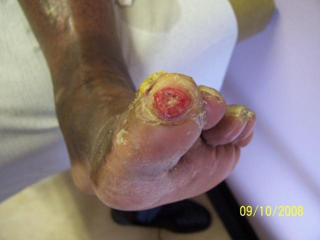

In [232]:
resized_img

In [239]:
import torchvision.transforms as T
transform = T.ToTensor()  # Transform to convert the PIL image to a tensor
tensor_img = transform(resized_img).unsqueeze(0)

In [240]:
tensor_img.shape

torch.Size([1, 3, 240, 320])

In [245]:
min_row, min_col, max_row, max_col = props[1].bbox

# Crop the original image corresponding to the batch index
cropped_img = tensor_img[batch_idx:batch_idx+1, :, min_row:max_row, min_col:max_col]

# Resize the cropped image to 224x224 for ViT
cropped_img_resized = F.interpolate(cropped_img, size=(224, 224), mode='bilinear', align_corners=False)


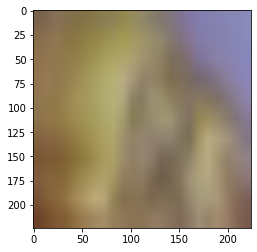

In [246]:
plt.imshow(cropped_img_resized.squeeze(0).permute(1,2,0).cpu())

In [ ]:
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes
fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow(unnorm(img)[0].permute(1,2,0).cpu())
ax[0].set_title("Image")
ax[1].imshow(model.label_cmap[cluster_pred])
ax[1].set_title("Cluster Predictions")
ax[2].imshow(pred.cpu().numpy(),'gray')
ax[2].set_title("Cluster Predictions")
remove_axes(ax)